In [10]:
# Install required packages if not already installed
try:
    from tqdm.keras import TqdmCallback
except ImportError:
    print("Installing tqdm...")
    import subprocess
    subprocess.check_call(["pip", "install", "tqdm"])
    from tqdm.keras import TqdmCallback

import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, initializers, regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import time
import matplotlib.animation as animation
from scipy.spatial.distance import pdist, squareform
from scipy.spatial.transform import Rotation as R
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from sklearn.metrics.pairwise import euclidean_distances

# Configure GPU memory growth before any TensorFlow operations
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled")
    except RuntimeError as e:
        print(e)

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define the base path to the Kaggle input folder
BASE_PATH = Path("/kaggle/input")
DATA_PATH = BASE_PATH / "stanford-rna-3d-folding"

print("Listing files in the dataset folder:")
for file in DATA_PATH.iterdir():
    size_mb = round(file.stat().st_size / (1024 * 1024), 2)
    print(f"{file.name} - {size_mb} MB")

GPU memory growth enabled
Listing files in the dataset folder:
MSA - 0.0 MB
sample_submission.csv - 0.18 MB
validation_sequences.csv - 0.01 MB
test_sequences.csv - 0.01 MB
validation_labels.csv - 2.37 MB
train_labels.csv - 9.21 MB
train_sequences.csv - 2.91 MB


In [11]:
# Load train_sequences.csv
train_seq_path = DATA_PATH / "train_sequences.csv"
train_sequences = pd.read_csv(train_seq_path)
print("Training Sequences:")
print(train_sequences.head())
print("Shape:", train_sequences.shape)

# Load train_labels.csv
train_labels_path = DATA_PATH / "train_labels.csv"
train_labels = pd.read_csv(train_labels_path)
print("\nTraining Labels:")
print(train_labels.head())
print("Shape:", train_labels.shape)

Training Sequences:
  target_id                            sequence temporal_cutoff  \
0    1SCL_A       GGGUGCUCAGUACGAGAGGAACCGCACCC      1995-01-26   
1    1RNK_A  GGCGCAGUGGGCUAGCGCCACUCAAAAGGCCCAU      1995-02-27   
2    1RHT_A            GGGACUGACGAUCACGCAGUCUAU      1995-06-03   
3    1HLX_A                GGGAUAACUUCGGUUGUCCC      1995-09-15   
4    1HMH_E  GGCGACCCUGAUGAGGCCGAAAGGCCGAAACCGU      1995-12-07   

                                         description  \
0               THE SARCIN-RICIN LOOP, A MODULAR RNA   
1  THE STRUCTURE OF AN RNA PSEUDOKNOT THAT CAUSES...   
2  24-MER RNA HAIRPIN COAT PROTEIN BINDING SITE F...   
3  P1 HELIX NUCLEIC ACIDS (DNA/RNA) RIBONUCLEIC ACID   
4  THREE-DIMENSIONAL STRUCTURE OF A HAMMERHEAD RI...   

                                       all_sequences  
0  >1SCL_1|Chain A|RNA SARCIN-RICIN LOOP|Rattus n...  
1  >1RNK_1|Chain A|RNA PSEUDOKNOT|null\nGGCGCAGUG...  
2  >1RHT_1|Chain A|RNA (5'-R(P*GP*GP*GP*AP*CP*UP*...  
3  >1HLX_1|Chain A|R

In [12]:
# Extract target_id from the 'ID' column in train_labels.csv
train_labels['target_id'] = train_labels['ID'].apply(lambda x: "_".join(x.split('_')[:-1]))

# Group the labels by target_id and count the number of residues per target
labels_grouped = train_labels.groupby('target_id').size().reset_index(name='num_residues')
print("Residue counts for some targets:")
print(labels_grouped.head())

# Merge this info with train_sequences.csv on target_id
merged = pd.merge(train_sequences, labels_grouped, left_on='target_id', right_on='target_id', how='left')
merged['sequence_length'] = merged['sequence'].apply(len)
print("\nComparison of sequence length and number of residues:")
print(merged[['target_id', 'sequence_length', 'num_residues']].head())

Residue counts for some targets:
  target_id  num_residues
0    17RA_A            21
1    1A1T_B            20
2    1A4T_A            15
3    1A51_A            41
4    1A60_A            44

Comparison of sequence length and number of residues:
  target_id  sequence_length  num_residues
0    1SCL_A               29            29
1    1RNK_A               34            34
2    1RHT_A               24            24
3    1HLX_A               20            20
4    1HMH_E               34            34


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


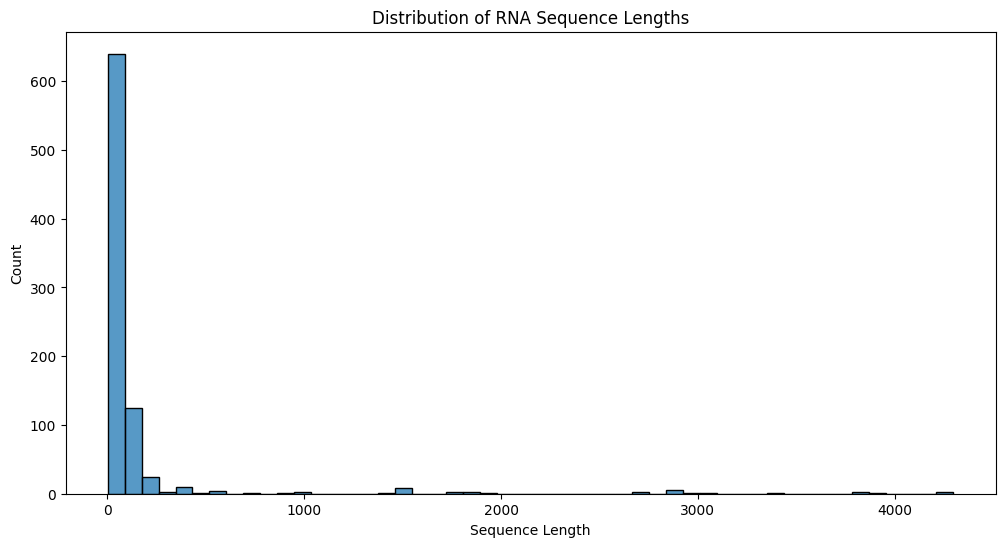

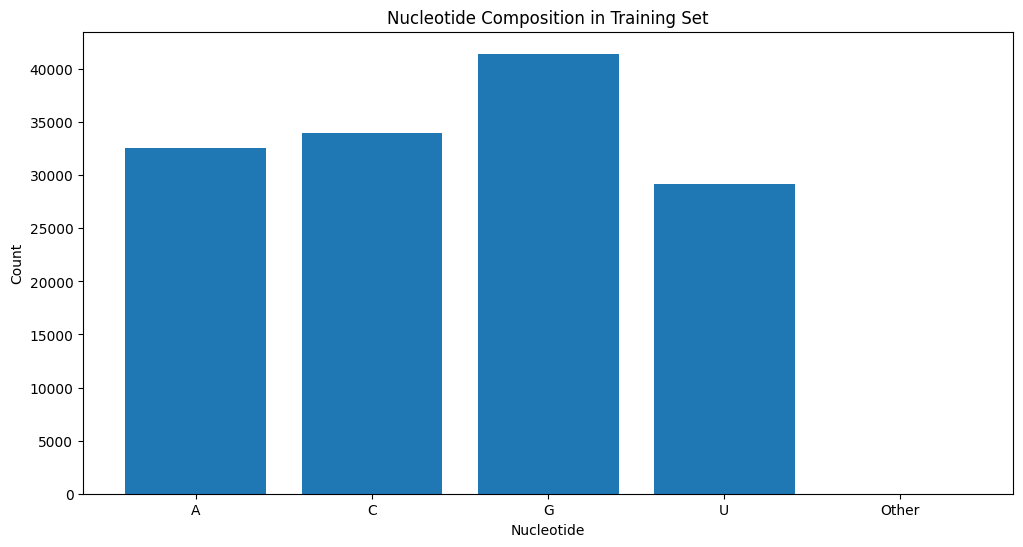


Detailed Nucleotide Composition:
A: 32524 (23.72%)
C: 33937 (24.75%)
G: 41450 (30.23%)
U: 29178 (21.28%)
Other: 6 (0.00%)


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


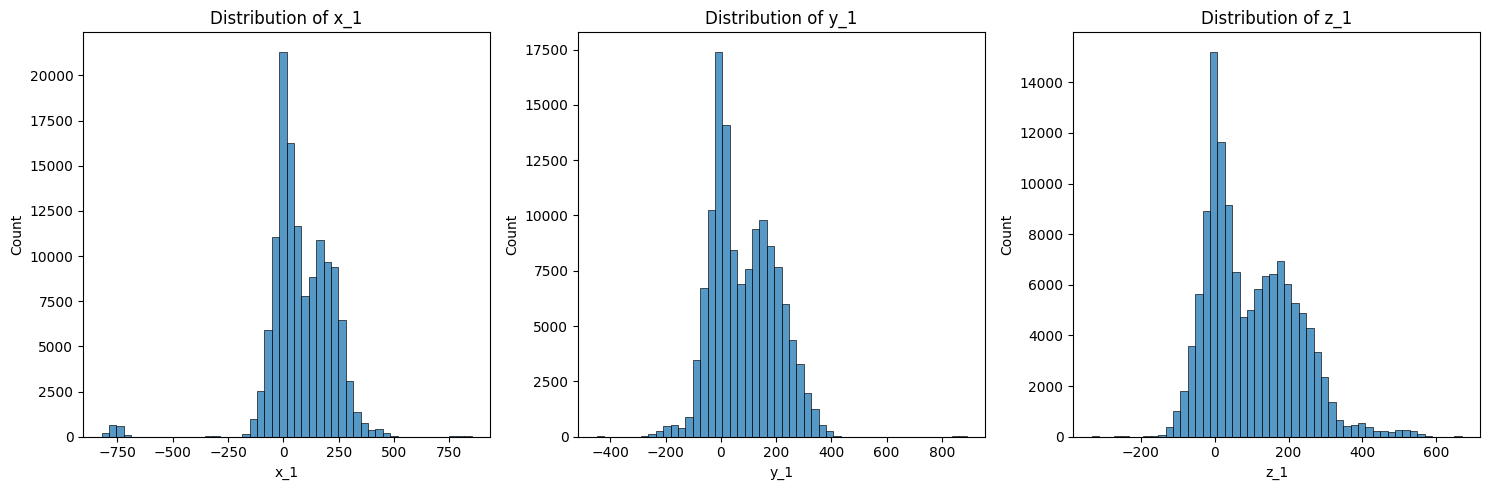

In [13]:
# 1. Sequence Length Distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=merged, x='sequence_length', bins=50)
plt.title('Distribution of RNA Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.show()

# 2. Nucleotide Composition Analysis
def analyze_nucleotide_composition(sequences):
    nucleotides = {'A': 0, 'C': 0, 'G': 0, 'U': 0, 'Other': 0}
    for seq in sequences:
        for nuc in seq:
            if nuc in nucleotides:
                nucleotides[nuc] += 1
            else:
                nucleotides['Other'] += 1
    return nucleotides

nucleotide_counts = analyze_nucleotide_composition(merged['sequence'])
plt.figure(figsize=(12, 6))
plt.bar(nucleotide_counts.keys(), nucleotide_counts.values())
plt.title('Nucleotide Composition in Training Set')
plt.xlabel('Nucleotide')
plt.ylabel('Count')
plt.show()

# Print detailed composition statistics
total_nucleotides = sum(nucleotide_counts.values())
print("\nDetailed Nucleotide Composition:")
for nuc, count in nucleotide_counts.items():
    percentage = (count / total_nucleotides) * 100
    print(f"{nuc}: {count} ({percentage:.2f}%)")

# 3. Coordinate Distribution Analysis
coord_cols = [col for col in train_labels.columns if col.startswith(('x_', 'y_', 'z_'))]
plt.figure(figsize=(15, 5))
for i, coord in enumerate(['x_1', 'y_1', 'z_1'], 1):
    plt.subplot(1, 3, i)
    sns.histplot(data=train_labels[coord], bins=50)
    plt.title(f'Distribution of {coord}')
plt.tight_layout()
plt.show()

In [14]:
# Define nucleotide-to-index mapping
nuc_to_idx = {'A': 0, 'C': 1, 'G': 2, 'U': 3}

def preprocess_data(sequences_df, labels_df):
    X_data = []
    y_data = []
    skipped = []
    
    for _, row in sequences_df.iterrows():
        target_id = row['target_id']
        seq = row['sequence']
        
        # Tokenize sequence
        tokenized = [nuc_to_idx[nuc] for nuc in seq if nuc in nuc_to_idx]
        
        # One-hot encode
        one_hot = np.eye(4)[tokenized]
        
        # Get matching coordinates
        coords_df = labels_df[labels_df['target_id'] == target_id]
        if coords_df.shape[0] != len(seq):
            skipped.append(target_id)
            continue
        
        # Extract x, y, z coordinates with structure-preserving normalization
        coords = coords_df[['x_1', 'y_1', 'z_1']].values
        
        # Check for invalid values and skip if found
        if np.isnan(coords).any() or np.isinf(coords).any():
            skipped.append(target_id)
            continue
            
        # Structure-preserving normalization:
        # Center the molecule at origin but preserve scale and relative positions
        coords_center = np.mean(coords, axis=0)
        coords_centered = coords - coords_center
        
        # Optional: Scale to unit variance while preserving shape
        scale_factor = np.std(np.linalg.norm(coords_centered, axis=1))
        coords_normalized = coords_centered / (scale_factor + 1e-8)
        
        X_data.append(one_hot)
        y_data.append(coords_normalized)
    
    return X_data, y_data, skipped

# Process training data
X_data, y_data, skipped = preprocess_data(train_sequences, train_labels)
print(f"✅ Processed {len(X_data)} sequences")
print(f"⛔ Skipped {len(skipped)} sequences due to mismatched lengths or invalid values")

# Use a manageable sequence length 
max_seq_len = 1000
print(f"Using sequence length: {max_seq_len}")

# Pad or truncate sequences to fixed length
X_padded = []
y_padded = []

for x, y in zip(X_data, y_data):
    if len(x) > max_seq_len:
        # Take the first max_seq_len elements
        X_padded.append(x[:max_seq_len])
        y_padded.append(y[:max_seq_len])
    else:
        # Pad with zeros
        x_pad = np.zeros((max_seq_len, 4), dtype='float32')
        y_pad = np.zeros((max_seq_len, 3), dtype='float32')
        x_pad[:len(x)] = x
        y_pad[:len(y)] = y
        X_padded.append(x_pad)
        y_padded.append(y_pad)

X_padded = np.array(X_padded, dtype='float32')
y_padded = np.array(y_padded, dtype='float32')

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_padded, y_padded, test_size=0.1, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")

✅ Processed 606 sequences
⛔ Skipped 238 sequences due to mismatched lengths or invalid values
Using sequence length: 1000
Training set shape: (545, 1000, 4)
Validation set shape: (61, 1000, 4)


In [15]:
# Compute distance matrix as a Keras Layer
class ComputeDistanceMatrix(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def call(self, coords):
        # Shape: [batch, seq_len, 3]
        r = tf.reduce_sum(coords ** 2, axis=2, keepdims=True)  # [batch, seq_len, 1]
        r_t = tf.transpose(r, perm=[0, 2, 1])  # [batch, 1, seq_len]
        
        # Calculate squared distances using batch matrix multiplication
        squared_dist = r - 2 * tf.matmul(coords, tf.transpose(coords, perm=[0, 2, 1])) + r_t
        
        # Ensure no negative distances due to numerical issues
        squared_dist = tf.maximum(squared_dist, 0.0)
        
        # Return distance matrix
        return tf.sqrt(squared_dist + 1e-8)  # [batch, seq_len, seq_len]

# Updated Graph attention refinement layer with Keras operations
class GraphAttentionRefinement(tf.keras.layers.Layer):
    def __init__(self, hidden_size=128, num_heads=4, name="graph_attention_refinement", **kwargs):
        super().__init__(name=name, **kwargs)
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        
        # Compute distance matrix layer
        self.compute_distances = ComputeDistanceMatrix()
        
        # Projection layers
        self.node_projection = tf.keras.layers.Dense(hidden_size)
        
        # Feature concatenation layer
        self.concat_layer = tf.keras.layers.Concatenate(axis=-1)
        
        # Graph attention layers
        self.attention_layers = []
        self.layer_norms = []
        
        for i in range(3):
            self.attention_layers.append(
                tf.keras.layers.MultiHeadAttention(
                    num_heads=num_heads, 
                    key_dim=hidden_size // num_heads
                )
            )
            self.layer_norms.append(
                tf.keras.layers.LayerNormalization(epsilon=1e-6)
            )
        
        # Output projection
        self.output_projection = tf.keras.layers.Dense(3)
        
        # Refinement scale factor
        self.refinement_scale = 0.1
    
    def build(self, input_shape):
        # Initialize variables or weights if needed
        super().build(input_shape)
    
    def call(self, inputs):
        coords, features = inputs
        
        # Compute distance matrix
        dist_matrix = self.compute_distances(coords)  # [batch, seq_len, seq_len]
        
        # Create node features by combining sequence and coordinate information
        node_features = self.concat_layer([
            features,  # Sequence features [batch, seq_len, feature_dim]
            coords     # Coordinate features [batch, seq_len, 3]
        ])
        
        # Project node features
        node_embeddings = self.node_projection(node_features)  # [batch, seq_len, hidden_size]
        
        # Apply graph attention layers with residual connections
        x = node_embeddings
        
        for i in range(3):
            # Create attention mask to limit attention to nearby residues (15Å neighborhood)
            attention_mask = tf.cast(dist_matrix < 15.0, tf.float32)
            
            # Apply attention with residual connection
            attn_output = self.attention_layers[i](
                query=x, key=x, value=x, 
                attention_mask=attention_mask
            )
            x = x + attn_output  # Residual connection
            x = self.layer_norms[i](x)  # Layer normalization
        
        # Project to coordinate space
        coord_refinement = self.output_projection(x)  # [batch, seq_len, 3]
        
        # Apply refinement as a residual update with scaling
        refined_coords = coords + self.refinement_scale * coord_refinement
        
        return refined_coords

# Add a custom positional encoding layer
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, d_model, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model
        
    def build(self, input_shape):
        seq_len = input_shape[1]
        # Create positional encoding matrix
        position = np.arange(seq_len)[:, np.newaxis]
        div_term = np.exp(np.arange(0, self.d_model, 2) * (-np.log(10000.0) / self.d_model))
        
        pos_encoding = np.zeros((1, seq_len, self.d_model))
        pos_encoding[0, :, 0::2] = np.sin(position * div_term)
        pos_encoding[0, :, 1::2] = np.cos(position * div_term)
        
        # Create a non-trainable weight
        self.pos_encoding = self.add_weight(
            shape=(1, seq_len, self.d_model),
            initializer=tf.keras.initializers.Constant(pos_encoding),
            trainable=False,
            name='positional_encoding'
        )
        super().build(input_shape)
        
    def call(self, inputs):
        return inputs + self.pos_encoding

# Update model building function to include both outputs
def build_structure_aware_rna_model(seq_len=max_seq_len):
    """
    Build a structure-aware RNA model with transformer encoder and refinement.
    """
    # Input layer (one-hot encoded RNA sequence)
    inputs = layers.Input(shape=(seq_len, 4))
    
    # Sequence encoding block
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    
    # Embedding to higher dimension
    x = layers.Conv1D(256, 1, activation=None)(x)
    
    # Add positional encoding using custom layer
    x = PositionalEncoding(d_model=256)(x)
    
    # Transformer blocks
    for _ in range(6):
        # Self-attention block
        attn_output = layers.MultiHeadAttention(
            num_heads=8, key_dim=32, dropout=0.1
        )(x, x)
        x = layers.Add()([x, attn_output])
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        
        # Feedforward block
        ffn = layers.Dense(512, activation='gelu')(x)
        ffn = layers.Dropout(0.1)(ffn)
        ffn = layers.Dense(256)(ffn)
        x = layers.Add()([x, ffn])
        x = layers.LayerNormalization(epsilon=1e-6)(x)
    
    # Capture multi-scale features with dilated convolutions
    conv1 = layers.Conv1D(128, 3, padding='same', dilation_rate=1, activation='relu')(x)
    conv2 = layers.Conv1D(128, 3, padding='same', dilation_rate=2, activation='relu')(x)
    conv3 = layers.Conv1D(128, 3, padding='same', dilation_rate=4, activation='relu')(x)
    
    # Combine multi-scale features
    multi_scale_features = layers.Concatenate()([conv1, conv2, conv3, x])
    
    # Final representation before coordinate prediction
    x = layers.Conv1D(256, 1, activation='relu')(multi_scale_features)
    
    # Initial coordinate prediction
    initial_coords = layers.Dense(3, activation=None, name='initial_coords')(x)
    
    # Apply learned refinement using graph attention network
    refined_coords = GraphAttentionRefinement(
        hidden_size=256, 
        num_heads=4,
        name='refined_coords'
    )([initial_coords, x])
    
    # Create model with both outputs as a dictionary
    model = tf.keras.Model(
        inputs=inputs, 
        outputs={
            'initial_coords': initial_coords,
            'refined_coords': refined_coords
        }
    )
    
    return model

In [16]:
# Distance matrix loss - captures pairwise relationships
def distance_matrix_loss(y_true, y_pred, max_dist=30.0):
    # Calculate pairwise distances for true coords
    def get_distance_matrix(coords):
        # Check if coords is a list (multiple outputs from the model)
        if isinstance(coords, list):
            coords = coords[1]  # Get refined coordinates
            
        # For memory efficiency, limit to the first 100 nucleotides
        coords = coords[:, :100, :]
        
        # Reshape for broadcasting
        r = tf.expand_dims(coords, axis=2)  # Shape: [batch, seq, 1, 3]
        s = tf.expand_dims(coords, axis=1)  # Shape: [batch, 1, seq, 3]
        
        # Calculate squared distances
        dist = tf.reduce_sum(tf.square(r - s), axis=-1)  # [batch, seq, seq]
        dist = tf.sqrt(dist + 1e-8)  # Add epsilon for stability
        
        # Clip to reasonable range to prevent extreme values
        dist = tf.clip_by_value(dist, 0.0, max_dist)
        return dist
    
    # Get distance matrices
    true_dist_matrix = get_distance_matrix(y_true)
    pred_dist_matrix = get_distance_matrix(y_pred)
    
    # Calculate mean squared error on distance matrices
    return tf.reduce_mean(tf.square(true_dist_matrix - pred_dist_matrix), axis=[1, 2])

# Simplified backbone vector orientation loss
def simplified_orientation_loss(y_true, y_pred):
    """A simpler approach that avoids torsion angles but still captures chain geometry"""
    # Check if y_pred is a list (multiple outputs from model)
    if isinstance(y_pred, list):
        y_pred = y_pred[1]  # Get refined coordinates
    
    # For memory efficiency, limit to first 100 nucleotides
    y_true = y_true[:, :100, :]
    y_pred = y_pred[:, :100, :]
    
    # Calculate vectors between adjacent points in the backbone
    true_vecs = y_true[:, 1:, :] - y_true[:, :-1, :]  # Shape: [batch, 99, 3]
    pred_vecs = y_pred[:, 1:, :] - y_pred[:, :-1, :]  # Shape: [batch, 99, 3]
    
    # Normalize vectors
    true_vecs_norm = tf.norm(true_vecs, axis=2, keepdims=True)
    pred_vecs_norm = tf.norm(pred_vecs, axis=2, keepdims=True)
    
    true_vecs = true_vecs / (true_vecs_norm + 1e-8)
    pred_vecs = pred_vecs / (pred_vecs_norm + 1e-8)
    
    # Calculate dot products between corresponding normalized vectors
    # This measures how well-aligned the backbone vectors are
    dot_products = tf.reduce_sum(true_vecs * pred_vecs, axis=2)  # Shape: [batch, 99]
    
    # Convert to angle differences: dot_product = cos(angle)
    # Small angles have dot products close to 1, misaligned vectors have dot products close to -1
    angle_diffs = tf.acos(tf.clip_by_value(dot_products, -0.9999, 0.9999))  # Shape: [batch, 99]
    
    # Return mean angle difference
    return tf.reduce_mean(angle_diffs, axis=1)  # Shape: [batch]

# Coordinate MSE loss
def coordinate_loss(y_true, y_pred):
    # Check if y_pred is a list (multiple outputs from model)
    if isinstance(y_pred, list):
        y_pred = y_pred[1]  # Get refined coordinates
        
    return tf.reduce_mean(tf.square(y_pred - y_true), axis=[1, 2])

# Add GDT-TS loss component
def gdt_ts_loss(y_true, y_pred):
    """Calculate a differentiable approximation of GDT-TS for use in training"""
    # Check if y_pred is a list (multiple outputs from model)
    if isinstance(y_pred, list):
        y_pred = y_pred[1]  # Get refined coordinates
    
    # For memory efficiency, limit to first 100 nucleotides
    y_true = y_true[:, :100, :]
    y_pred = y_pred[:, :100, :]
    
    # Calculate distances between corresponding points
    squared_diff = tf.reduce_sum(tf.square(y_true - y_pred), axis=2)  # [batch, seq_len]
    distances = tf.sqrt(squared_diff)  # [batch, seq_len]
    
    # GDT-TS cutoffs (in Angstroms)
    cutoffs = [1.0, 2.0, 4.0, 8.0]
    
    # Calculate the percentage of residues below each threshold
    # Using soft thresholds for differentiability
    percentages = []
    for cutoff in cutoffs:
        # Soft threshold using sigmoid with temperature parameter
        temp = 0.1  # Controls sharpness of transition
        within_cutoff = tf.sigmoid((cutoff - distances) / temp)  # [batch, seq_len]
        percentage = tf.reduce_mean(within_cutoff, axis=1) * 100.0  # [batch]
        percentages.append(percentage)
    
    # GDT-TS is the average of the percentages
    gdt_ts = tf.reduce_mean(tf.stack(percentages, axis=1), axis=1)  # [batch]
    
    # Convert to loss (higher GDT-TS = lower loss)
    return 100.0 - gdt_ts  # [batch]

# Create specialized loss function with RNA-specific components
class RNAStructureAwareLoss(tf.keras.losses.Loss):
    def __init__(self, coord_weight=1.0, dist_weight=0.6, orient_weight=0.8, gdt_weight=1.0, **kwargs):
        super().__init__(**kwargs)
        self.coord_weight = coord_weight
        self.dist_weight = dist_weight
        self.orient_weight = orient_weight
        self.gdt_weight = gdt_weight
        
    def call(self, y_true, y_pred):
        # Use the refined coordinates for loss calculation
        if isinstance(y_pred, list):
            y_pred = y_pred[1]  # Get refined coordinates
        
        # Coordinate MSE loss
        coord_loss = coordinate_loss(y_true, y_pred)
        
        # Distance matrix loss
        dist_loss = distance_matrix_loss(y_true, y_pred)
        
        # Orientation loss
        orient_loss = simplified_orientation_loss(y_true, y_pred)
        
        # GDT-TS based loss
        gdt_loss = gdt_ts_loss(y_true, y_pred)
        
        # Combined loss
        total_loss = (
            self.coord_weight * coord_loss + 
            self.dist_weight * dist_loss +
            self.orient_weight * orient_loss +
            self.gdt_weight * gdt_loss
        )
        
        return total_loss

# Custom metric to extract MAE on refined coordinates
def refined_mae(y_true, y_pred):
    # y_pred is [initial_coords, refined_coords]
    if isinstance(y_pred, list):
        y_pred = y_pred[1]  # Get refined coordinates
        
    return tf.reduce_mean(tf.abs(y_pred - y_true), axis=[1, 2])

# Build model with a simplified approach
model = build_structure_aware_rna_model()

In [19]:
# Train the model directly with separate stages
print("\nTraining RNA structure prediction model...")

# Stage 1: Train only the initial coordinates
print("\nStage 1: Training initial coordinate prediction...")

# Configure the model for initial training
for layer in model.layers:
    layer.trainable = True  # Start with all layers trainable

# Compile model with specific losses for each output
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss={
        'initial_coords': coordinate_loss,
        'refined_coords': lambda y_true, y_pred: 0  # Zero loss for refinement during initial training
    },
    loss_weights={
        'initial_coords': 1.0,
        'refined_coords': 0.0
    }
)

# Train initial prediction without early stopping
print("Training initial coordinates (fixed 15 epochs)...")
history_initial = model.fit(
    X_train, 
    {
        'initial_coords': y_train, 
        'refined_coords': y_train
    },
    validation_data=(
        X_val, 
        {
            'initial_coords': y_val, 
            'refined_coords': y_val
        }
    ),
    epochs=50,
    batch_size=16,
    verbose=1
)

# Stage 2: Freeze initial prediction and train refinement
print("\nStage 2: Training structure refinement...")

# Freeze all layers except refinement
for layer in model.layers:
    if isinstance(layer, GraphAttentionRefinement) or 'refined_coords' in layer.name:
        layer.trainable = True
        print(f"Layer {layer.name} is trainable")
    else:
        layer.trainable = False

# Compile with refinement losses
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss={
        'initial_coords': lambda y_true, y_pred: 0,  # Zero loss for initial during refinement
        'refined_coords': RNAStructureAwareLoss(
            coord_weight=1.0,
            dist_weight=0.6,
            orient_weight=0.8,
            gdt_weight=1.0
        )
    },
    loss_weights={
        'initial_coords': 0.0,
        'refined_coords': 1.0
    },
    metrics={
        'refined_coords': refined_mae
    }
)

# Train refinement without early stopping
print("Training refinement (fixed 20 epochs)...")
history_refinement = model.fit(
    X_train, 
    {
        'initial_coords': y_train,
        'refined_coords': y_train
    },
    validation_data=(
        X_val, 
        {
            'initial_coords': y_val,
            'refined_coords': y_val
        }
    ),
    epochs=20,
    batch_size=16,
    verbose=1
)

# Save the final model
model.save('rna_structure_model.keras')
print("Model saved to 'rna_structure_model.keras'")


Training RNA structure prediction model...

Stage 1: Training initial coordinate prediction...
Training initial coordinates (fixed 15 epochs)...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 61s 774ms/step - initial_coords_loss: 0.7001 - loss: 0.7005 - refined_coords_loss: 0.0000e+00 - val_initial_coords_loss: 0.2182 - val_loss: 0.2173 - val_refined_coords_loss: 0.0000e+00
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 233ms/step - initial_coords_loss: 0.3629 - loss: 0.3632 - refined_coords_loss: 0.0000e+00 - val_initial_coords_loss: 0.2005 - val_loss: 0.1996 - val_refined_coords_loss: 0.0000e+00
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 233ms/step - initial_coords_loss: 0.3416 - loss: 0.3419 - refined_coords_loss: 0.0000e+00 - val_initial_coords_loss: 0.1983 - val_loss: 0.1975 - val_refined_coords_loss: 0.0000e+00
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 233ms/step - initial_coords_loss: 0.3350 - loss: 0.3353 - refined_coords_loss: 0.0000e+00 - val_initial_coords_loss: 0.1978 - val_loss: 0.1970 - val_refined_coords_loss: 0.0000e+00
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 233ms/step - initial_coords_loss: 0.3317 - loss: 0.3320 - refined_coords_loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         'initial_coords': lambda y_true, y_pred: 0,  # Zero loss for initial during refinement

  return {key: serialize_keras_object(value) for key, value in obj.items()}


Model saved to 'rna_structure_model.keras'


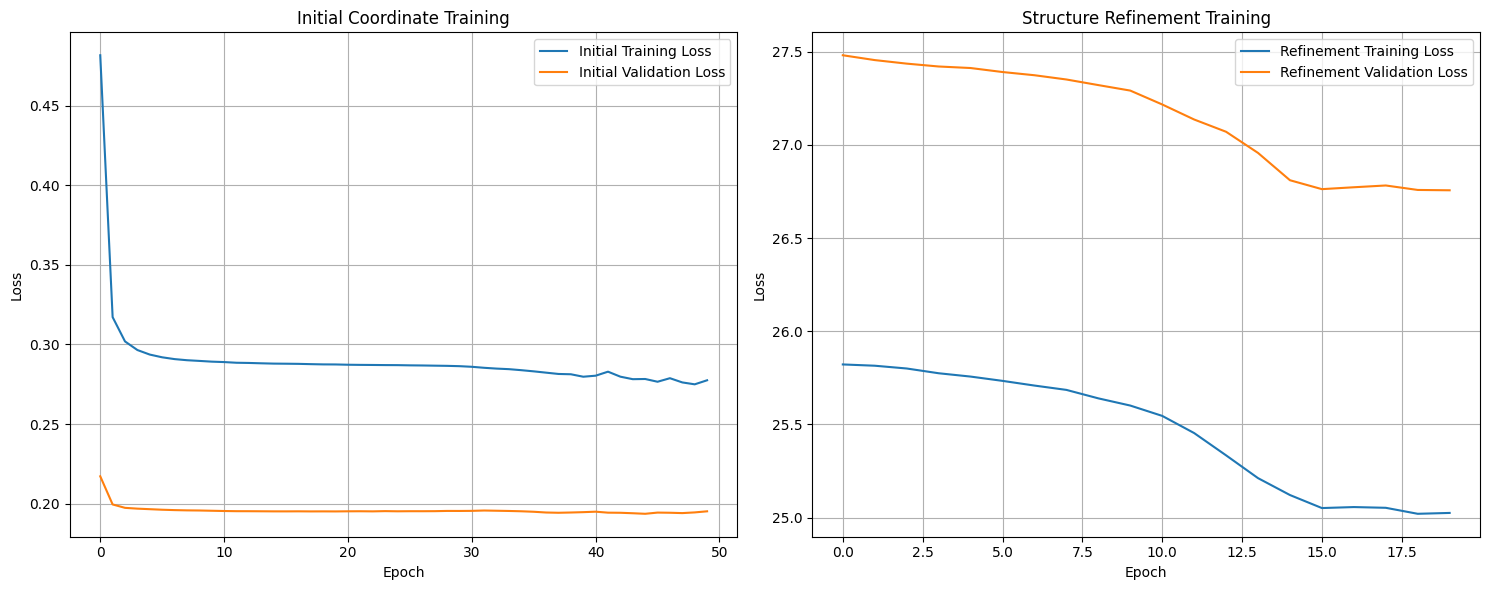

In [20]:
# Plot training results
plt.figure(figsize=(15, 6))

# Loss for initial training
plt.subplot(1, 2, 1)
plt.plot(history_initial.history['loss'], label='Initial Training Loss')
if 'val_loss' in history_initial.history:
    plt.plot(history_initial.history['val_loss'], label='Initial Validation Loss')
plt.title('Initial Coordinate Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Loss for refinement
plt.subplot(1, 2, 2)
plt.plot(history_refinement.history['loss'], label='Refinement Training Loss')
if 'val_loss' in history_refinement.history:
    plt.plot(history_refinement.history['val_loss'], label='Refinement Validation Loss')
plt.title('Structure Refinement Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [25]:
# Update visualization function to handle dictionary outputs
def visualize_rna_structure(model, sample_input, true_coords, fig_size=(15, 10)):
    """
    Visualize RNA structure prediction with initial and refined coordinates
    """
    # Generate predictions
    predictions = model.predict(sample_input)
    
    # Extract coordinates from dictionary outputs
    initial_coords = predictions['initial_coords']
    refined_coords = predictions['refined_coords']
    
    # Extract first sample
    true = true_coords[0]
    initial = initial_coords[0]
    refined = refined_coords[0]
    
    # Create 3D plot
    fig = plt.figure(figsize=fig_size)
    
    # True structure
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot(true[:100, 0], true[:100, 1], true[:100, 2], 'b-', linewidth=2, alpha=0.7)
    ax1.scatter(true[:100, 0], true[:100, 1], true[:100, 2], c='blue', s=20)
    ax1.set_title('True Structure')
    
    # Initial prediction
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.plot(initial[:100, 0], initial[:100, 1], initial[:100, 2], 'r-', linewidth=2, alpha=0.7)
    ax2.scatter(initial[:100, 0], initial[:100, 1], initial[:100, 2], c='red', s=20)
    ax2.set_title('Initial Prediction')
    
    # Refined prediction
    ax3 = fig.add_subplot(133, projection='3d')
    ax3.plot(refined[:100, 0], refined[:100, 1], refined[:100, 2], 'g-', linewidth=2, alpha=0.7)
    ax3.scatter(refined[:100, 0], refined[:100, 1], refined[:100, 2], c='green', s=20)
    ax3.set_title('Refined Prediction')
    
    # Set common aspects and limits
    for ax in [ax1, ax2, ax3]:
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_xlim(-5, 5)
        ax.set_ylim(-5, 5)
        ax.set_zlim(-5, 5)
    
    plt.tight_layout()
    plt.show()
    
    return initial, refined

In [24]:
# Update the metrics calculation section
def evaluate_model_metrics(model, sample_input, sample_true):
    """Calculate structural metrics for a sample"""
    # Make predictions
    predictions = model.predict(sample_input)
    
    # Extract coordinates from dictionary outputs
    initial_coords = predictions['initial_coords']
    refined_coords = predictions['refined_coords']
    
    # Get coordinates from first batch item
    true_coords = sample_true[0][:100]
    initial_coords = initial_coords[0][:100]
    refined_coords = refined_coords[0][:100]
    
    # Calculate RMSD
    initial_rmsd = calculate_rmsd(true_coords, initial_coords)
    refined_rmsd = calculate_rmsd(true_coords, refined_coords)
    print(f"Initial RMSD: {initial_rmsd:.4f}Å")
    print(f"Refined RMSD: {refined_rmsd:.4f}Å")
    print(f"RMSD Improvement: {100*(initial_rmsd-refined_rmsd)/initial_rmsd:.2f}%")
    
    # Calculate GDT-TS
    initial_gdt = calculate_gdt_ts(true_coords, initial_coords)
    refined_gdt = calculate_gdt_ts(true_coords, refined_coords)
    print(f"Initial GDT-TS: {initial_gdt:.2f}%")
    print(f"Refined GDT-TS: {refined_gdt:.2f}%")
    print(f"GDT-TS Improvement: {refined_gdt-initial_gdt:.2f}%")
    
    # Calculate contact maps
    true_cm = calculate_contact_map(true_coords)
    initial_cm = calculate_contact_map(initial_coords)
    refined_cm = calculate_contact_map(refined_coords)
    
    # Calculate contact map overlap
    initial_cmo = calculate_contact_map_overlap(true_cm, initial_cm)
    refined_cmo = calculate_contact_map_overlap(true_cm, refined_cm)
    print(f"Initial Contact Map Overlap (F1): {initial_cmo['f1']:.4f}")
    print(f"Refined Contact Map Overlap (F1): {refined_cmo['f1']:.4f}")
    print(f"Contact Map Overlap Improvement: {100*(refined_cmo['f1']-initial_cmo['f1'])/max(0.0001, initial_cmo['f1']):.2f}%")
    
    # Calculate backbone angles
    true_angles = calculate_backbone_angles(true_coords)
    initial_angles = calculate_backbone_angles(initial_coords)
    refined_angles = calculate_backbone_angles(refined_coords)
    
    return {
        'true_coords': true_coords,
        'initial_coords': initial_coords,
        'refined_coords': refined_coords,
        'metrics': {
            'initial_rmsd': initial_rmsd,
            'refined_rmsd': refined_rmsd,
            'initial_gdt': initial_gdt,
            'refined_gdt': refined_gdt,
            'initial_cmo': initial_cmo,
            'refined_cmo': refined_cmo
        },
        'angles': {
            'true_angles': true_angles,
            'initial_angles': initial_angles,
            'refined_angles': refined_angles
        },
        'contact_maps': {
            'true_cm': true_cm,
            'initial_cm': initial_cm,
            'refined_cm': refined_cm
        }
    }


Evaluating structure-aware model...
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - initial_coords_loss: 0.0000e+00 - loss: 25.6148 - refined_coords_loss: 25.7329 - refined_coords_refined_mae: 0.1715
Structure-Aware Validation Loss: 26.7560
Structure-Aware Validation MAE: 0.1804

Generating structure-aware visualization...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


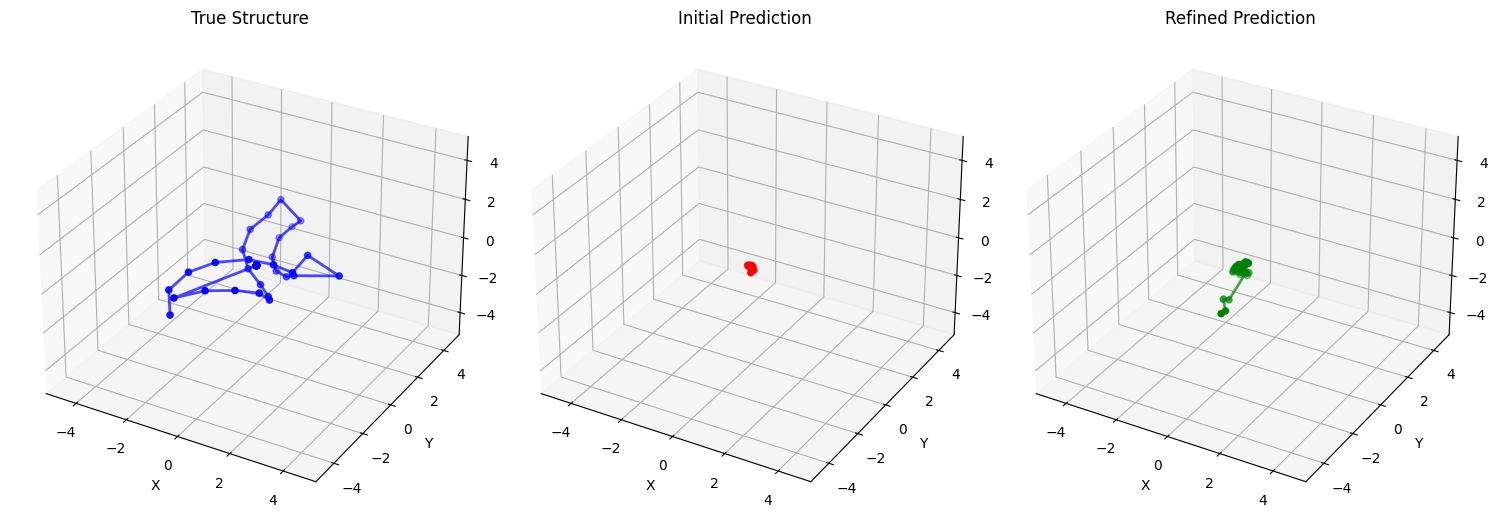


Calculating structural metrics...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


NameError: name 'calculate_rmsd' is not defined

In [23]:
# Update the model evaluation and visualization section
print("\nEvaluating structure-aware model...")
val_results = model.evaluate(X_val, {'initial_coords': y_val, 'refined_coords': y_val}, verbose=1)
print(f"Structure-Aware Validation Loss: {val_results[0]:.4f}")
print(f"Structure-Aware Validation MAE: {val_results[-1]:.4f}")

# Visualize a sample prediction
print("\nGenerating structure-aware visualization...")
sample_idx = np.random.randint(0, len(X_val))
sample_input = X_val[sample_idx:sample_idx+1]
sample_true = y_val[sample_idx:sample_idx+1]

initial, refined = visualize_rna_structure(model, sample_input, sample_true)

# Calculate metrics for the sample
print("\nCalculating structural metrics...")
metrics_results = evaluate_model_metrics(model, sample_input, sample_true)

# Use these variables for the enhanced visualization
true_coords = metrics_results['true_coords']
initial_coords = metrics_results['initial_coords']
refined_coords = metrics_results['refined_coords']
true_cm = metrics_results['contact_maps']['true_cm']
initial_cm = metrics_results['contact_maps']['initial_cm']
refined_cm = metrics_results['contact_maps']['refined_cm']
true_angles = metrics_results['angles']['true_angles']
initial_angles = metrics_results['angles']['initial_angles']
refined_angles = metrics_results['angles']['refined_angles']
initial_rmsd = metrics_results['metrics']['initial_rmsd']
refined_rmsd = metrics_results['metrics']['refined_rmsd']
initial_gdt = metrics_results['metrics']['initial_gdt']
refined_gdt = metrics_results['metrics']['refined_gdt']
initial_cmo = metrics_results['metrics']['initial_cmo']
refined_cmo = metrics_results['metrics']['refined_cmo']

In [26]:
# ======================================
# Enhanced Structure Evaluation Metrics
# ======================================

def calculate_rmsd(coords1, coords2):
    """Calculate Root Mean Square Deviation between two sets of coordinates"""
    # Ensure same shape
    min_len = min(len(coords1), len(coords2))
    coords1 = coords1[:min_len]
    coords2 = coords2[:min_len]
    
    # Calculate squared differences
    squared_diff = np.sum((coords1 - coords2) ** 2, axis=1)
    
    # Return RMSD
    return np.sqrt(np.mean(squared_diff))

def calculate_contact_map(coords, threshold=8.0):
    """Calculate a contact map from 3D coordinates using a distance threshold"""
    # Calculate pairwise distances
    dist_matrix = euclidean_distances(coords)
    
    # Create contact map (1 if distance < threshold, 0 otherwise)
    contact_map = np.where(dist_matrix < threshold, 1, 0)
    
    # Set diagonal to 0 (no self-contacts)
    np.fill_diagonal(contact_map, 0)
    
    return contact_map

def calculate_contact_map_overlap(cm1, cm2):
    """Calculate the overlap between two contact maps"""
    # Ensure same shape
    min_len = min(len(cm1), len(cm2))
    cm1 = cm1[:min_len, :min_len]
    cm2 = cm2[:min_len, :min_len]
    
    # Calculate true positives, false positives, false negatives
    true_pos = np.sum(np.logical_and(cm1 == 1, cm2 == 1))
    false_pos = np.sum(np.logical_and(cm1 == 0, cm2 == 1))
    false_neg = np.sum(np.logical_and(cm1 == 1, cm2 == 0))
    
    # Calculate precision, recall, F1 score
    precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
    recall = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    # Calculate Jaccard similarity
    jaccard = true_pos / (true_pos + false_pos + false_neg) if (true_pos + false_pos + false_neg) > 0 else 0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'jaccard': jaccard
    }

def calculate_gdt_ts(coords1, coords2):
    """Calculate Global Distance Test - Total Score (GDT-TS)"""
    # Cutoffs for GDT-TS (in Angstroms)
    cutoffs = [1.0, 2.0, 4.0, 8.0]
    
    # Ensure same shape
    min_len = min(len(coords1), len(coords2))
    coords1 = coords1[:min_len]
    coords2 = coords2[:min_len]
    
    # Calculate distances between corresponding points
    distances = np.sqrt(np.sum((coords1 - coords2) ** 2, axis=1))
    
    # Calculate percentage of points within each cutoff
    percentages = []
    for cutoff in cutoffs:
        within_cutoff = np.sum(distances < cutoff)
        percentage = 100.0 * within_cutoff / min_len
        percentages.append(percentage)
    
    # GDT-TS is the average of the percentages
    gdt_ts = np.mean(percentages)
    
    return gdt_ts

def calculate_backbone_angles(coords):
    """Calculate pseudo-dihedral angles from backbone coordinates (similar to Ramachandran)"""
    if len(coords) < 4:
        return np.array([])
    
    # Calculate vectors between consecutive atoms
    vectors = coords[1:] - coords[:-1]
    
    # Need 3 consecutive vectors to form a dihedral
    angles = []
    for i in range(len(vectors) - 2):
        # Get 3 consecutive vectors
        v1 = vectors[i]
        v2 = vectors[i+1]
        v3 = vectors[i+2]
        
        # Calculate normal vectors to planes
        n1 = np.cross(v1, v2)
        n2 = np.cross(v2, v3)
        
        # Normalize normal vectors
        n1_norm = np.linalg.norm(n1)
        n2_norm = np.linalg.norm(n2)
        
        if n1_norm < 1e-6 or n2_norm < 1e-6:
            angles.append(0)
            continue
            
        n1 = n1 / n1_norm
        n2 = n2 / n2_norm
        
        # Calculate the dot product and handle numerical precision issues
        dot_product = np.clip(np.dot(n1, n2), -1.0, 1.0)
        
        # Get the angle
        angle = np.arccos(dot_product)
        
        # Determine sign of angle
        cross_product = np.cross(n1, n2)
        if np.dot(cross_product, v2) < 0:
            angle = -angle
            
        angles.append(angle)
    
    return np.array(angles)


Generating enhanced visualizations...


NameError: name 'true_coords' is not defined

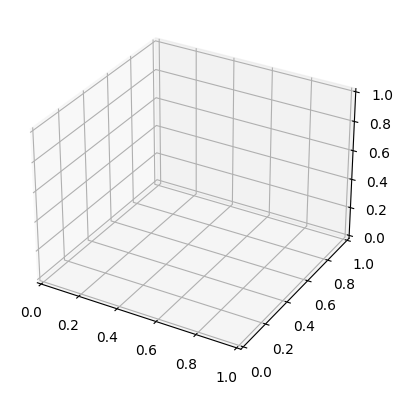

In [27]:
# ======================================
# Enhanced Visualization
# ======================================

print("\nGenerating enhanced visualizations...")

# Create a larger figure with GridSpec for layout
fig = plt.figure(figsize=(20, 16))
gs = gridspec.GridSpec(3, 3)

# 3D Structure plot
ax1 = fig.add_subplot(gs[0, 0], projection='3d')
ax1.plot(true_coords[:, 0], true_coords[:, 1], true_coords[:, 2], 'bo-', linewidth=2, markersize=5, label='True')
ax1.set_title('True Structure')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.grid(True)

# Contact Maps
ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(true_cm, cmap='Blues', origin='lower')
ax2.set_title('True Contact Map')
ax2.set_xlabel('Nucleotide Index')
ax2.set_ylabel('Nucleotide Index')

# Contact Map Difference (Refined - True)
ax3 = fig.add_subplot(gs[0, 2])
diff_cm = refined_cm - true_cm
cmap = LinearSegmentedColormap.from_list('contact_diff', ['red', 'white', 'green'])
im = ax3.imshow(diff_cm, cmap=cmap, origin='lower', vmin=-1, vmax=1)
ax3.set_title('Contact Map Difference (Refined - True)')
ax3.set_xlabel('Nucleotide Index')
ax3.set_ylabel('Nucleotide Index')
plt.colorbar(im, ax=ax3)

# RNA "Ramachandran" Plot (using consecutive backbone angles)
ax4 = fig.add_subplot(gs[1, 0])
if len(true_angles) > 1 and len(refined_angles) > 1:
    # We'll plot angle_i vs angle_i+1
    ax4.scatter(true_angles[:-1], true_angles[1:], c='blue', alpha=0.7, label='True')
    ax4.scatter(refined_angles[:-1], refined_angles[1:], c='green', alpha=0.7, label='Refined')
    ax4.set_title('RNA Backbone Angle Plot')
    ax4.set_xlabel('Angle i (radians)')
    ax4.set_ylabel('Angle i+1 (radians)')
    ax4.set_xlim(-np.pi, np.pi)
    ax4.set_ylim(-np.pi, np.pi)
    ax4.legend()
    ax4.grid(True)
else:
    ax4.text(0.5, 0.5, 'Not enough points for angle plot', 
             horizontalalignment='center', verticalalignment='center')

# Define the animation function for structure morphing
def update_line(num, true_line, pred_line):
    # Interpolate between initial and refined predictions
    interp_factor = num / 50
    interp_coords = initial_coords * (1 - interp_factor) + refined_coords * interp_factor
    
    # Update the lines
    pred_line.set_data(interp_coords[:, 0], interp_coords[:, 1])
    pred_line.set_3d_properties(interp_coords[:, 2])
    
    return [pred_line]

# Create the animation axes
ax5 = fig.add_subplot(gs[1, 1:], projection='3d')
true_line, = ax5.plot(true_coords[:, 0], true_coords[:, 1], true_coords[:, 2], 'bo-', 
                     linewidth=2, markersize=5, label='True')
pred_line, = ax5.plot(initial_coords[:, 0], initial_coords[:, 1], initial_coords[:, 2], 'ro-', 
                     linewidth=2, markersize=5, label='Prediction')
ax5.set_title('Structure Morphing Animation')
ax5.set_xlabel('X')
ax5.set_ylabel('Y')
ax5.set_zlabel('Z')
ax5.legend()

# Create the animation
ani = animation.FuncAnimation(fig, update_line, frames=51, fargs=(true_line, pred_line),
                             interval=100, blit=True)

# Calculate per-residue RMSD
per_residue_rmsd = np.sqrt(np.sum((true_coords - refined_coords) ** 2, axis=1))

# Local quality plot (per-residue RMSD)
ax6 = fig.add_subplot(gs[2, 0])
ax6.bar(range(len(per_residue_rmsd)), per_residue_rmsd, color='skyblue')
ax6.set_title('Local Quality (Per-Residue RMSD)')
ax6.set_xlabel('Residue Index')
ax6.set_ylabel('RMSD (Å)')
ax6.grid(True, axis='y')
# Add a horizontal line for the average RMSD
ax6.axhline(y=np.mean(per_residue_rmsd), color='red', linestyle='--', 
           label=f'Average: {np.mean(per_residue_rmsd):.2f}Å')
ax6.legend()

# Summary metrics text box
ax7 = fig.add_subplot(gs[2, 1:])
ax7.axis('off')
metrics_text = (
    f"STRUCTURE QUALITY METRICS:\n\n"
    f"RMSD (Root Mean Square Deviation):\n"
    f"   Initial: {initial_rmsd:.4f}Å\n"
    f"   Refined: {refined_rmsd:.4f}Å\n"
    f"   Improvement: {100*(initial_rmsd-refined_rmsd)/initial_rmsd:.2f}%\n\n"
    f"GDT-TS (Global Distance Test):\n"
    f"   Initial: {initial_gdt:.2f}%\n"
    f"   Refined: {refined_gdt:.2f}%\n"
    f"   Improvement: {refined_gdt-initial_gdt:.2f}%\n\n"
    f"Contact Map Overlap (F1 Score):\n"
    f"   Initial: {initial_cmo['f1']:.4f}\n"
    f"   Refined: {refined_cmo['f1']:.4f}\n"
    f"   Improvement: {100*(refined_cmo['f1']-initial_cmo['f1'])/max(0.0001, initial_cmo['f1']):.2f}%\n\n"
    f"Worst 5 Residues (Highest RMSD):\n"
    f"   Indices: {np.argsort(per_residue_rmsd)[-5:][::-1]}\n"
    f"   Values: {sorted(per_residue_rmsd)[-5:][::-1]}"
)
ax7.text(0.05, 0.95, metrics_text, fontsize=12, family='monospace', 
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()

# Save as GIF and show the figure
ani.save('rna_structure_morphing.gif', writer='pillow')
plt.savefig('rna_structure_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nAnalysis complete!")
print("Saved animation as 'rna_structure_morphing.gif'")
print("Saved analysis as 'rna_structure_analysis.png'")